In [7]:
import pandas as pd

data = pd.read_csv("/Users/amanarya/quant/projects/HMMs/^SPX.csv")
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-11-28,4545.549805,4568.140137,4540.509766,4554.890137,4554.890137,3586240000
1,2023-11-29,4571.839844,4587.640137,4547.149902,4550.580078,4550.580078,4418760000
2,2023-11-30,4554.870117,4569.890137,4537.240234,4567.799805,4567.799805,5399300000
3,2023-12-01,4559.430176,4599.390137,4554.709961,4594.629883,4594.629883,4397120000
4,2023-12-04,4564.370117,4572.370117,4546.720215,4569.779785,4569.779785,4369910000


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM

In [13]:
# Calculate the fractional changes
data['fracChange'] = (data['Close'] - data['Open']) / data['Open']
data['fracHigh'] = (data['High'] - data['Open']) / data['Open']
data['fracLow'] = (data['Open'] - data['Low']) / data['Open']

# Discretize the data
nfc, nfh, nfl = 50, 10, 10

fracChange_bins = np.linspace(data['fracChange'].min(), data['fracChange'].max(), nfc)
fracHigh_bins = np.linspace(data['fracHigh'].min(), data['fracHigh'].max(), nfh)
fracLow_bins = np.linspace(data['fracLow'].min(), data['fracLow'].max(), nfl)

data['disc_fracChange'] = np.digitize(data['fracChange'], fracChange_bins)
data['disc_fracHigh'] = np.digitize(data['fracHigh'], fracHigh_bins)
data['disc_fracLow'] = np.digitize(data['fracLow'], fracLow_bins)

# Combine the discretized features into a single state space
data['state'] = (data['disc_fracLow'] - 1) * (nfc * nfh) + (data['disc_fracHigh'] - 1) * nfc + data['disc_fracChange']

data.iloc[:10,-7:]


,fracChange,fracHigh,fracLow,disc_fracChange,disc_fracHigh,disc_fracLow,state
0,0.002055,0.004970,0.001109,32,4,1,182
1,-0.004650,0.003456,0.005400,22,3,3,1122
2,0.002839,0.003298,0.003871,34,3,2,634
3,0.007720,0.008764,0.001035,41,6,1,291
4,0.001185,0.001753,0.003867,31,2,2,581
5,0.002179,0.004676,0.001222,33,4,1,183
6,-0.008044,0.000983,0.008663,17,1,5,2017
7,0.003666,0.004833,0.000792,35,4,1,185
8,0.006156,0.007218,0.000468,39,5,1,239
9,0.006324,0.006601,0.000000,39,5,1,239


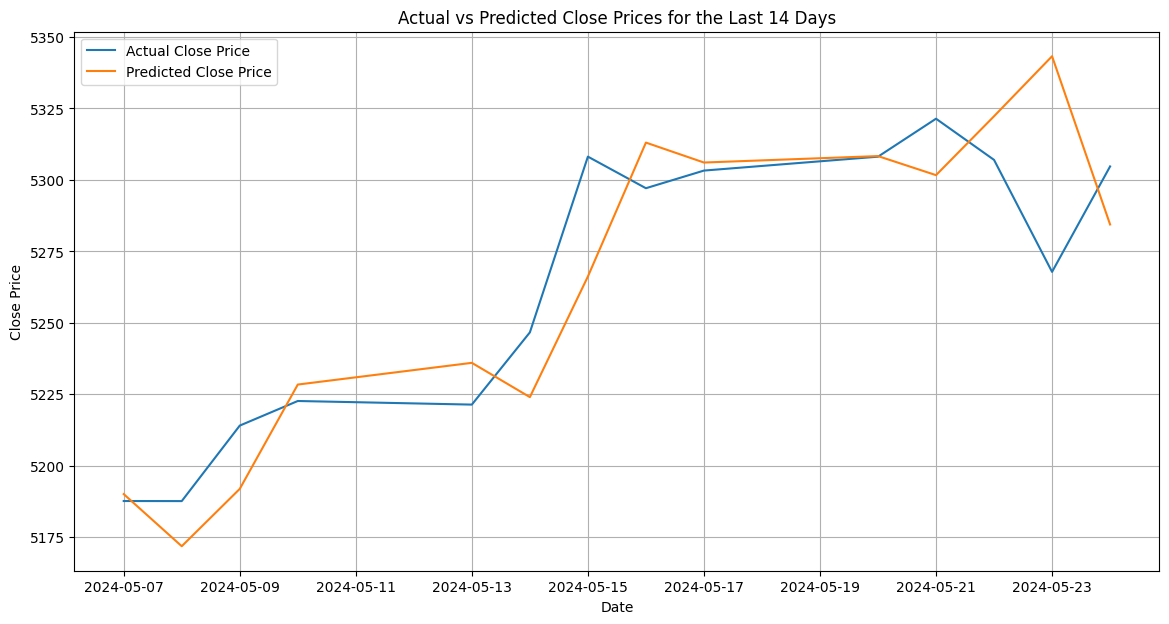

In [3]:

# Prepare training data
X = data[['fracChange', 'fracHigh', 'fracLow']].values

# Train the HMM
model = GaussianHMM(n_components=4, covariance_type="diag", n_iter=1000)
model.fit(X)

# Predict the stock prices for the last 14 days
n_days = 14
predicted_close = []

for i in range(len(data) - n_days, len(data)):
    recent_data = X[i-n_days:i]
    hidden_states = model.predict(recent_data)
    
    # Predict the next day's state
    next_state = model.transmat_[hidden_states[-1]].argmax()
    mean_fracChange = model.means_[next_state][0]
    
    next_open = data.iloc[i]['Open']
    predicted_close.append(next_open * (1 + mean_fracChange))

# Plot the actual vs predicted close prices
plt.figure(figsize=(14, 7))
plt.plot(data['Date'].iloc[-n_days:], data['Close'].iloc[-n_days:], label='Actual Close Price')
plt.plot(data['Date'].iloc[-n_days:], predicted_close, label='Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Prices for the Last 14 Days')
plt.legend()
plt.grid(True)
plt.show()
